In [2]:
import numpy as np
from dataclasses import dataclass

# =========================
# Canonical units & constants
# =========================
# Sun-centered, planar (2D), nondimensional:
#   Length = 1 AU, Time = sqrt(AU^3 / mu_sun)  => mu_sun = 1
MU = 1.0
aE, aM = 1.0, 1.524
nE, nM = 1/np.sqrt(aE**3), 1/np.sqrt(aM**3)

# =========================
# Ephemerides (circular, 2D)
# =========================
def planet_state(a, n, t, phase=0.0):
    """Return [x, y, vx, vy] for a circular orbit of radius a and mean motion n."""
    ang = n*t + phase
    ca, sa = np.cos(ang), np.sin(ang)
    x, y = a*ca, a*sa
    vx, vy = -a*n*sa, a*n*ca
    return np.array([x, y, vx, vy], dtype=float)

# =========================
# Two-body dynamics
# =========================
def accel(r):
    rnorm = np.linalg.norm(r)
    return -r / (rnorm**3)

def f_two_body(t, y):
    r, v = y[:2], y[2:]
    a = accel(r)
    return np.array([v[0], v[1], a[0], a[1]], dtype=float)

# =========================
# Integrators (consistent signature: (f, t, y, h))
# =========================
def step_euler(f, t, y, h):
    return y + h * f(t, y)

def step_rk4(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + 0.5*h, y + 0.5*h*k1)
    k3 = f(t + 0.5*h, y + 0.5*h*k2)
    k4 = f(t + h, y + h*k3)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def step_leapfrog(f, t, y, h):
    # Velocity-Verlet; uses direct accel() for efficiency
    r = y[:2].copy()
    v = y[2:].copy()
    a0 = accel(r)
    v_half = v + 0.5*h*a0
    r_new = r + h*v_half
    a1 = accel(r_new)
    v_new = v_half + 0.5*h*a1
    return np.array([r_new[0], r_new[1], v_new[0], v_new[1]], dtype=float)

STEPPERS = {
    "euler": step_euler,
    "rk4": step_rk4,
    "leapfrog": step_leapfrog
}

# =========================
# Hohmann helper (inner → outer)
# =========================
def hohmann_inner_to_outer(a1, a2):
    at = 0.5*(a1 + a2)
    t_trans = np.pi*np.sqrt(at**3 / MU)
    # Required Mars-ahead phase angle at launch (so that arrival meets Mars)
    dphi0 = np.pi - (1/np.sqrt(a2**3))*t_trans  # = pi - nM * t_trans
    dv1 = np.sqrt(1/a1)*(np.sqrt(2*a2/(a1+a2)) - 1)
    dv2 = np.sqrt(1/a2)*(1 - np.sqrt(2*a1/(a1+a2)))
    return dphi0, dv1, dv2, t_trans

# =========================
# Propagation
# =========================
@dataclass
class SimConfig:
    t0: float
    tf: float
    h: float
    method: str = "leapfrog"   # "euler" | "rk4" | "leapfrog"

def propagate(y0, cfg: SimConfig, f=f_two_body):
    stepper = STEPPERS[cfg.method]
    steps = int(np.ceil((cfg.tf - cfg.t0) / cfg.h))
    t = cfg.t0
    y = y0.astype(float).copy()
    out = np.empty((steps + 1, 1 + y.size), dtype=float)
    out[0, 0], out[0, 1:] = t, y
    for k in range(1, steps + 1):
        y = stepper(f, t, y, cfg.h)
        t = cfg.t0 + k*cfg.h
        out[k, 0], out[k, 1:] = t, y
    return out

# =========================
# Diagnostics
# =========================
def specific_energy(y):
    r, v = y[:2], y[2:]
    return 0.5*np.dot(v, v) - MU/np.linalg.norm(r)

# =========================
# Set up Hohmann-like transfer
# =========================
dphi0, dv1, dv2, t_trans = hohmann_inner_to_outer(aE, aM)

# Earth and Mars at t=0
stateE0 = planet_state(aE, nE, t=0.0, phase=0.0)
stateM0 = planet_state(aM, nM, t=0.0, phase=dphi0)

rE0, vE0 = stateE0[:2], stateE0[2:]
tangential_hat = vE0 / np.linalg.norm(vE0)

# Spacecraft initial state: at Earth, with tangential burn dv1
r0 = rE0.copy()
v0 = vE0 + dv1 * tangential_hat
y0 = np.hstack((r0, v0))

# =========================
# Run three solvers
# =========================
cfg_leap = SimConfig(t0=0.0, tf=1.1*t_trans, h=2e-3, method="leapfrog")
cfg_rk4  = SimConfig(t0=0.0, tf=1.1*t_trans, h=2e-3, method="rk4")
cfg_eul  = SimConfig(t0=0.0, tf=0.5*t_trans, h=2e-3, method="euler")  # Euler will degrade faster

trajL = propagate(y0, cfg_leap)
trajR = propagate(y0, cfg_rk4)
trajE = propagate(y0, cfg_eul)

# =========================
# Energy error (relative)
# =========================
E0 = specific_energy(y0)
relE_L = np.abs(np.array([specific_energy(row[1:]) for row in trajL]) - E0) / abs(E0)
relE_R = np.abs(np.array([specific_energy(row[1:]) for row in trajR]) - E0) / abs(E0)
relE_E = np.abs(np.array([specific_energy(row[1:]) for row in trajE]) - E0) / abs(E0)

# =========================
# Simple intercept check near nominal arrival
# =========================
t_arr = trajL[-1, 0]
r_sc_arr = trajL[-1, 1:3]
rM_arr = planet_state(aM, nM, t_arr, phase=dphi0)[:2]
miss_distance_AU = np.linalg.norm(r_sc_arr - rM_arr)

print(f"Phase angle (rad): {dphi0:.6f}")
print(f"Δv1 (canonical):   {dv1:.6f}")
print(f"Transfer time T:   {t_trans:.6f} (canonical)")
print(f"Miss distance @arrival: {miss_distance_AU:.6e} AU")

# (Optional) quick sanity prints for energy behavior
print("\nRel. energy error at end:")
print(f"  Leapfrog: {relE_L[-1]:.3e}")
print(f"  RK4:      {relE_R[-1]:.3e}")
print(f"  Euler:    {relE_E[-1]:.3e}")


Phase angle (rad): 0.774248
Δv1 (canonical):   0.098912
Transfer time T:   4.453884 (canonical)
Miss distance @arrival: 3.934222e-02 AU

Rel. energy error at end:
  Leapfrog: 5.487e-07
  RK4:      1.100e-13
  Euler:    7.757e-03


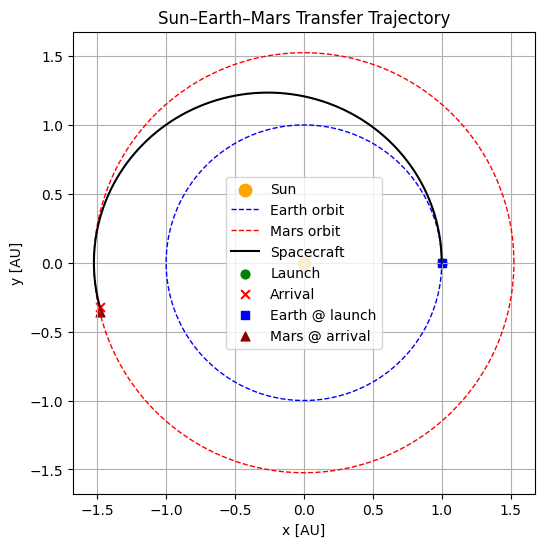

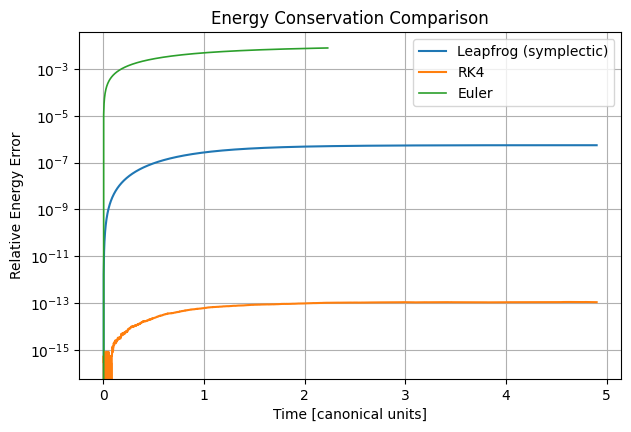

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- 1) 2D Trajectory Plot ----------
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
ax.grid(True)

# Sun
ax.scatter([0], [0], c='orange', s=80, label='Sun')

# Reference circular orbits
theta = np.linspace(0, 2*np.pi, 600)
ax.plot(aE*np.cos(theta), aE*np.sin(theta), 'b--', lw=1, label='Earth orbit')
ax.plot(aM*np.cos(theta), aM*np.sin(theta), 'r--', lw=1, label='Mars orbit')

# Spacecraft trajectory (Leapfrog)
ax.plot(trajL[:,1], trajL[:,2], 'k', lw=1.5, label='Spacecraft')

# Mark start & end points
ax.scatter(trajL[0,1], trajL[0,2], c='green', s=40, marker='o', label='Launch')
ax.scatter(trajL[-1,1], trajL[-1,2], c='red', s=40, marker='x', label='Arrival')

# Earth and Mars positions at launch/arrival
rE0_plot = planet_state(aE, nE, 0.0)[:2]
rM_arr   = planet_state(aM, nM, trajL[-1,0], phase=dphi0)[:2]
ax.scatter(rE0_plot[0], rE0_plot[1], color='blue', s=30, marker='s', label='Earth @ launch')
ax.scatter(rM_arr[0], rM_arr[1], color='darkred', s=40, marker='^', label='Mars @ arrival')

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_title('Sun–Earth–Mars Transfer Trajectory')
ax.legend(loc='best')
plt.show()


# ---------- 2) Energy Error Plot ----------
E0 = specific_energy(y0)
relE_L = np.abs(np.array([specific_energy(row[1:]) for row in trajL]) - E0) / abs(E0)
relE_R = np.abs(np.array([specific_energy(row[1:]) for row in trajR]) - E0) / abs(E0)
relE_E = np.abs(np.array([specific_energy(row[1:]) for row in trajE]) - E0) / abs(E0)

plt.figure(figsize=(7,4.5))
plt.semilogy(trajL[:,0], relE_L, label='Leapfrog (symplectic)', lw=1.5)
plt.semilogy(trajR[:,0], relE_R, label='RK4', lw=1.5)
plt.semilogy(trajE[:,0], relE_E, label='Euler', lw=1.2)
plt.xlabel('Time [canonical units]')
plt.ylabel('Relative Energy Error')
plt.title('Energy Conservation Comparison')
plt.grid(True, which='both')
plt.legend()
plt.show()
